In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gc

In [ ]:
conn = sqlite3.connect('[...PATH...]/httparchive_processed/2020-01/assets.db')
try:
    assets_df = pd.read_sql('''
                            select  base_page, asset_url,
                                    mime_type,
                                    is_ad, is_tracker,
                                    hybrid_ident
                            from    assets_processed
                            ''',
                            con=conn)

except Exception as e:
    print(e)
finally:
    conn.close()

In [ ]:
assets_df['hybrid_ident'].replace({None : '-',
                                   'Amazon CloudFront' : 'Amazon',
                                   'Microsoft Azure' : 'Microsoft'}, inplace=True)

In [ ]:
# assets with same URL and distinct base pages -> shared assets
shared_assets = assets_df.groupby(['asset_url', 'mime_type', 'is_ad', 'is_tracker', 'hybrid_ident'],
                                  as_index=False
                                 )['base_page'].nunique()

In [ ]:
shared_df = pd.DataFrame(shared_assets).rename(columns={'base_page' : 'num_base_pages'})

In [ ]:
shared_df = shared_df[shared_df['num_base_pages'] > 1]

In [ ]:
shared_df.sort_values('num_base_pages', ascending=False, inplace=True)

In [ ]:
shared_df

In [ ]:
with sqlite3.connect('[...PATH...]/httparchive/shared-assets.db') as conn:
    shared_df.to_sql('shared_assets', if_exists='fail', index=False, con=conn)

In [2]:
# shortcut if already aggregated
# with sqlite3.connect('[...PATH...]/httparchive/shared-assets.db') as conn:
#     shared_df = pd.read_sql('select * from shared_assets', con=conn)

In [3]:
shared_df

,asset_url,mime_type,is_ad,is_tracker,hybrid_ident,num_base_pages
0,https://www.google-analytics.com/analytics.js,javascript,0,1,Google,2589685
1,https://connect.facebook.net/en_US/fbevents.js,javascript,0,1,Facebook,831262
2,https://staticxx.facebook.com/connect/xd_arbit...,html,0,0,Facebook,602078
3,https://fonts.gstatic.com/s/opensans/v17/mem8Y...,font,0,0,Google,534341
4,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,font,0,0,Google,484774
...,...,...,...,...,...,...
11741762,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2
11741763,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2
11741764,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2
11741765,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2


In [4]:
# percentage of shared assets relative to all assets in the dataset
11741766/392322373

0.029928871785244834

In [5]:
shared_df.groupby('num_base_pages').size()

num_base_pages
2          8883770
3          1279401
4           485743
5           233678
6           146168
            ...   
484774           1
534341           1
602078           1
831262           1
2589685          1
Length: 5659, dtype: int64

In [7]:
tmp_df = shared_df.groupby('num_base_pages').size().reset_index().rename(columns={0 : 'num_shared_assets'})

In [8]:
tmp_df

,num_base_pages,num_shared_assets
0,2,8883770
1,3,1279401
2,4,485743
3,5,233678
4,6,146168
...,...,...
5654,484774,1
5655,534341,1
5656,602078,1
5657,831262,1


In [9]:
tmp_df['cdf'] = tmp_df['num_shared_assets'].cumsum() / tmp_df['num_shared_assets'].sum()

In [10]:
tmp_df['ccdf'] = 1 - tmp_df['cdf']

In [11]:
tmp_df.round(5)

,num_base_pages,num_shared_assets,cdf,ccdf
0,2,8883770,0.75660,0.24340
1,3,1279401,0.86556,0.13444
2,4,485743,0.90693,0.09307
3,5,233678,0.92683,0.07317
4,6,146168,0.93928,0.06072
...,...,...,...,...
5654,484774,1,1.00000,0.00000
5655,534341,1,1.00000,0.00000
5656,602078,1,1.00000,0.00000
5657,831262,1,1.00000,0.00000


In [12]:
tmp_df[tmp_df['num_base_pages'] > 10]

,num_base_pages,num_shared_assets,cdf,ccdf
9,11,36902,0.965335,3.466497e-02
10,12,30655,0.967946,3.205420e-02
11,13,26963,0.970242,2.975787e-02
12,14,22494,0.972158,2.784215e-02
13,15,20000,0.973861,2.613883e-02
...,...,...,...,...
5654,484774,1,1.000000,3.406642e-07
5655,534341,1,1.000000,2.554982e-07
5656,602078,1,1.000000,1.703321e-07
5657,831262,1,1.000000,8.516606e-08


In [13]:
tmp_df[tmp_df['num_base_pages'] > 100]

,num_base_pages,num_shared_assets,cdf,ccdf
99,101,471,0.994829,5.171113e-03
100,102,483,0.994870,5.129977e-03
101,103,452,0.994909,5.091482e-03
102,104,478,0.994949,5.050773e-03
103,105,462,0.994989,5.011426e-03
...,...,...,...,...
5654,484774,1,1.000000,3.406642e-07
5655,534341,1,1.000000,2.554982e-07
5656,602078,1,1.000000,1.703321e-07
5657,831262,1,1.000000,8.516606e-08


In [14]:
import matplotlib.pyplot as plt

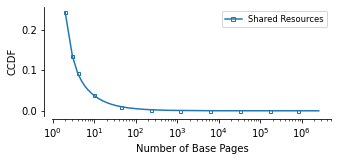

In [15]:
cdf_fig, cdf_ax = plt.subplots(figsize = (5, 2))

cdf_ax.plot(tmp_df['num_base_pages'], tmp_df['ccdf'],
                label = 'Shared Resources',
                marker = 's',
#                 linewidth = 0.5,
                markersize = 3,
#                 markeredgewidth = 0.5,
                fillstyle = 'none',
                color = 'C0',
                markevery=0.1
              )

# PLOT FORMATTING
# customize axes and grid appearance
cdf_ax.set_title('')
cdf_ax.legend(loc = 'upper right', markerscale = 1.5, fontsize = 'small')
cdf_ax.set_xlabel('Number of Base Pages')
cdf_ax.set_ylabel('CCDF')
cdf_ax.set_xscale('log')
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.03))
cdf_ax.spines['left'].set_position(('axes', -0.03))

plt.show()

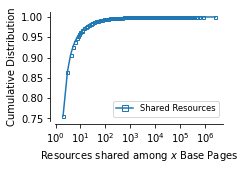

In [16]:
cdf_fig, cdf_ax = plt.subplots(figsize = (3, 2))

cdf_ax.plot(tmp_df['num_base_pages'], tmp_df['cdf'],
                label = 'Shared Resources',
                marker = 's',
#                 linewidth = 0.5,
                markersize = 3,
#                 markeredgewidth = 0.5,
                fillstyle = 'none',
                color = 'C0',
                markevery=0.01
              )

# PLOT FORMATTING
# customize axes and grid appearance
cdf_ax.set_title('')
cdf_ax.legend(loc = 'lower right', markerscale = 2, fontsize = 'small')
cdf_ax.set_xlabel('Resources shared among $\it{x}$ Base Pages')
cdf_ax.set_ylabel('Cumulative Distribution')
cdf_ax.set_xscale('log')
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.03))
cdf_ax.spines['left'].set_position(('axes', -0.03))

# cdf_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cdf_ax.set_yticks([0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
cdf_ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])

cdf_fig.savefig('./plots/cdf-shared-assets.pdf', bbox_inches='tight')
plt.show()

In [17]:
1375025+2903601

4278626

In [18]:
shared_df['page_percentage'] = shared_df['num_base_pages'] / (1375025+2903601)

In [19]:
shared_df

,asset_url,mime_type,is_ad,is_tracker,hybrid_ident,num_base_pages,page_percentage
0,https://www.google-analytics.com/analytics.js,javascript,0,1,Google,2589685,6.052609e-01
1,https://connect.facebook.net/en_US/fbevents.js,javascript,0,1,Facebook,831262,1.942825e-01
2,https://staticxx.facebook.com/connect/xd_arbit...,html,0,0,Facebook,602078,1.407176e-01
3,https://fonts.gstatic.com/s/opensans/v17/mem8Y...,font,0,0,Google,534341,1.248861e-01
4,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,font,0,0,Google,484774,1.133013e-01
...,...,...,...,...,...,...,...
11741762,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741763,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741764,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741765,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07


In [20]:
shared_df[shared_df['page_percentage'] >= 0.01]

,asset_url,mime_type,is_ad,is_tracker,hybrid_ident,num_base_pages,page_percentage
0,https://www.google-analytics.com/analytics.js,javascript,0,1,Google,2589685,0.605261
1,https://connect.facebook.net/en_US/fbevents.js,javascript,0,1,Facebook,831262,0.194282
2,https://staticxx.facebook.com/connect/xd_arbit...,html,0,0,Facebook,602078,0.140718
3,https://fonts.gstatic.com/s/opensans/v17/mem8Y...,font,0,0,Google,534341,0.124886
4,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,font,0,0,Google,484774,0.113301
...,...,...,...,...,...,...,...
225,https://googleads.g.doubleclick.net/pagead/drt/si,unidentified,0,0,Google,43654,0.010203
226,https://www.google.com/pagead/drt/ui,unidentified,1,0,Google,43428,0.010150
227,https://pay.shopify.com/session?v=1,application,0,0,Google,43313,0.010123
228,https://www.facebook.com/rsrc.php/v3/y3/r/GCE1...,javascript,0,0,Facebook,43016,0.010054


In [21]:
shared_df.index = np.arange(1, len(shared_df) + 1)  # shift index to start with 1

In [22]:
shared_df

,asset_url,mime_type,is_ad,is_tracker,hybrid_ident,num_base_pages,page_percentage
1,https://www.google-analytics.com/analytics.js,javascript,0,1,Google,2589685,6.052609e-01
2,https://connect.facebook.net/en_US/fbevents.js,javascript,0,1,Facebook,831262,1.942825e-01
3,https://staticxx.facebook.com/connect/xd_arbit...,html,0,0,Facebook,602078,1.407176e-01
4,https://fonts.gstatic.com/s/opensans/v17/mem8Y...,font,0,0,Google,534341,1.248861e-01
5,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,font,0,0,Google,484774,1.133013e-01
...,...,...,...,...,...,...,...
11741763,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741764,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741765,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07
11741766,https://guiaimpresion.com/wp-content/themes/li...,javascript,0,0,-,2,4.674398e-07


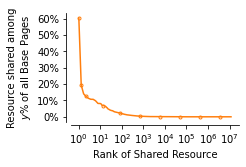

In [39]:
fig, ax = plt.subplots(figsize = (3, 2))

ax.plot(shared_df.index, shared_df['page_percentage'],
                label = 'Base Page Percentage',
                marker = 'o',
#                 linewidth = 0.5,
                markersize = 3,
#                 markeredgewidth = 0.5,
                fillstyle = 'none',
                color = 'C1',
                markevery=0.1
              )

# PLOT FORMATTING
# customize axes and grid appearance
ax.set_title('')
# ax.legend(loc = 'upper right', markerscale = 1.5, fontsize = 'small')
ax.legend().set_visible(False)
ax.set_xlabel('Rank of Shared Resource')
ax.set_ylabel('Resource shared among\n$y$% of all Base Pages')
ax.set_xscale('symlog', linthresh=10)
ax.set_xticks([10**i for i in range(8)])
ax.minorticks_off()
yticks = np.arange(0.0, 0.65, 0.1)
ax.set_yticks(yticks)
yticklabels = map(lambda x: '{:.0%}'.format(x), yticks)
ax.set_yticklabels(yticklabels)
ax.grid(False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.03))
ax.spines['left'].set_position(('axes', -0.03))

fig.savefig('./plots/shared-assets-percentages.pdf', bbox_inches='tight')

plt.show()

In [24]:
shared_df.head(10)

,asset_url,mime_type,is_ad,is_tracker,hybrid_ident,num_base_pages,page_percentage
1,https://www.google-analytics.com/analytics.js,javascript,0,1,Google,2589685,0.605261
2,https://connect.facebook.net/en_US/fbevents.js,javascript,0,1,Facebook,831262,0.194282
3,https://staticxx.facebook.com/connect/xd_arbit...,html,0,0,Facebook,602078,0.140718
4,https://fonts.gstatic.com/s/opensans/v17/mem8Y...,font,0,0,Google,534341,0.124886
5,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,font,0,0,Google,484774,0.113301
6,https://www.googletagservices.com/activeview/j...,javascript,0,0,Google,459071,0.107294
7,https://fonts.gstatic.com/s/roboto/v20/KFOmCnq...,font,0,0,Google,457614,0.106953
8,https://www.googleadservices.com/pagead/conver...,javascript,0,1,Google,419111,0.097955
9,https://static.doubleclick.net/instream/ad_sta...,javascript,1,0,Google,350456,0.081909
10,https://fonts.gstatic.com/s/opensans/v17/mem5Y...,font,0,0,Google,347705,0.081266


In [25]:
shared_df['mime_type'].replace({'unidentified' : 'other',
                                'no type' : 'other'}, inplace=True)

In [26]:
len(shared_df)

11741767

In [27]:
len(shared_df) / 392322373  # all assets

0.029928874334169058

In [28]:
shared_df['num_base_pages'].value_counts()

2         8883770
3         1279401
4          485743
5          233678
6          146168
           ...   
3617            1
110100          1
3618            1
3620            1
27008           1
Name: num_base_pages, Length: 5659, dtype: int64

In [29]:
(shared_df['num_base_pages'].value_counts() / len(shared_df)).round(5)

2         0.75660
3         0.10896
4         0.04137
5         0.01990
6         0.01245
           ...   
3617      0.00000
110100    0.00000
3618      0.00000
3620      0.00000
27008     0.00000
Name: num_base_pages, Length: 5659, dtype: float64

### By Provider

In [52]:
import Cdf
import matplotlib.pyplot as plt

In [53]:
shared_df['hybrid_ident'].value_counts()

-              5711737
Amazon         1359845
Cloudflare     1231017
Google         1125998
Akamai          586267
                ...   
PageCDN             29
PUSHR               27
Fly                 17
QUIC.cloud           2
Hosting4CDN          1
Name: hybrid_ident, Length: 80, dtype: int64

In [241]:
(shared_df['hybrid_ident'].value_counts() / len(shared_df)).round(5).head(10)

-             0.48645
Amazon        0.11581
Cloudflare    0.10484
Google        0.09590
Akamai        0.04993
Fastly        0.02412
Twitter       0.01950
Facebook      0.01690
Microsoft     0.01596
Edgecast      0.00948
Name: hybrid_ident, dtype: float64

In [261]:
shared_df.groupby('hybrid_ident')['num_base_pages'].max().sort_values(ascending=False).head(10)

hybrid_ident
Google        2589685
Facebook       831262
Twitter        293823
-              212510
section.io     177686
Edgecast       145240
Amazon         118429
Akamai         114459
Microsoft      109820
Fastly         107710
Name: num_base_pages, dtype: int64

In [259]:
(shared_df.groupby('hybrid_ident')['num_base_pages'].max().sort_values(ascending=False) / 4278626).round(5)

hybrid_ident
Google             0.60526
Facebook           0.19428
Twitter            0.06867
-                  0.04967
section.io         0.04153
                    ...   
Optimal CDN        0.00000
QUIC.cloud         0.00000
Pressable CDN      0.00000
Zycada Networks    0.00000
Hosting4CDN        0.00000
Name: num_base_pages, Length: 80, dtype: float64